In [1]:
import numpy as np
import pandas as pd
import cudf
import os
import time

In [2]:
from timeit import default_timer

class Timer(object):
    def __init__(self):
        self._timer = default_timer
    
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        """Start the timer."""
        self.start = self._timer()

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        self.interval = self.end - self.start

In [3]:
import gzip
def load_data(nrows, ncols, cached = 'data/mortgage.npy.gz'):
    X = np.random.rand(nrows,ncols)
    df = pd.DataFrame({'fea%d'%i:X[:,i].astype(np.float32) for i in range(X.shape[1])})
    return df

In [110]:
bench_dims = [64, 128, 256, 512])

In [119]:
import pickle

def perform_bench(func, name, rerun = False, out_filename = "benchmark.pickle", 
                  bench_rows = [2**x for x in range(10, 16)], bench_dims = bench_dims):
    
    if os.path.exists(out_filename):
        print("Opened benchmark results from %s" % (out_filename))
        with open(out_filename, 'rb') as f:
            final_results = pickle.load(f)
    else:
        final_results = {}
        
    if name in final_results:
        results = final_results[name]
    else:
        results = {}
        final_results[name] = results
        
    for n_rows in bench_rows:
        for n_dims in bench_dims:
            if (n_rows, n_dims) not in results or rerun:
                
                print("Running %s. (nrows=%d, n_dims=%d)" % (name, n_rows, n_dims))
                speedup = func(n_rows, n_dims)
                print("Speedup for %s = %d" % (str((n_rows, n_dims)), speedup))
                results[(n_rows, n_dims)] = speedup
                
                with open(out_filename, 'wb') as f:
                    pickle.dump(final_results, f, pickle.HIGHEST_PROTOCOL)
            
            
    

In [118]:
import numpy as np
import pandas as pd
import cudf
import numba
from librmm_cffi import librmm as rmm
from numba.cuda.cudadrv.driver import driver
import math
from numba import cuda

def row_matrix(df):
    # matrix = rmm.device_array(shape=(nrow, ncol), dtype=dtype, order='C')
    # for colidx, col in enumerate(cols):
    #     gpu_row_matrix.forall(matrix[:, colidx].size)(matrix[:, colidx],
    #                                                   col.to_gpu_array(),
    #                                                   nrow, ncol)
    """Compute the C (row major) version gpu matrix of df

    This implements the algorithm documented in
    http://devblogs.nvidia.com/parallelforall/efficient-matrix-transpose-cuda-cc/

    :param a: an `np.ndarray` or a `DeviceNDArrayBase` subclass. If already on
        the device its stream will be used to perform the transpose (and to copy
        `b` to the device if necessary).

    Adapted from numba:
    https://github.com/numba/numba/blob/master/numba/cuda/kernels/transpose.py
    """

    print("STARTING")

    cols = [df._cols[k] for k in df._cols]
    ncol = len(cols)
    nrow = len(df)
    dtype = cols[0].dtype

    a = df.as_gpu_matrix(order='F')
    b = rmm.device_array((nrow, ncol), dtype=dtype, order='C')
    dtype = numba.typeof(a)

    tpb = driver.get_device().MAX_THREADS_PER_BLOCK

    tile_width = int(math.pow(2, math.log(tpb, 2) / 2))
    tile_height = int(tpb / tile_width)

    tile_shape = (tile_height, tile_width + 1)

    @cuda.jit
    def kernel(input, output):

        tile = cuda.shared.array(shape=tile_shape, dtype=numba.float32)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        bx = cuda.blockIdx.x * cuda.blockDim.x
        by = cuda.blockIdx.y * cuda.blockDim.y
        y = by + tx
        x = bx + ty

        if by + ty < input.shape[0] and bx + tx < input.shape[1]:
            tile[ty, tx] = input[by + ty, bx + tx]
        cuda.syncthreads()
        if y < output.shape[0] and x < output.shape[1]:
            output[y, x] = tile[tx, ty]

    # one block per tile, plus one for remainders
    blocks = int(b.shape[1] / tile_height + 1), int(b.shape[0] / tile_width + 1)
    # one thread per tile element
    threads = tile_height, tile_width
    kernel[blocks, threads](a, b)

    return b


In [105]:
from sklearn.neighbors import KDTree as skKNN
from cuml import KNN as cumlKNN

def bench_knn(rows, dims):
    
    X = load_data(rows,int(dims / 2))
    n_neighbors = dims
    sk_start = time.time()
    knn_sk = skKNN(X)
    D_sk,I_sk = knn_sk.query(X,n_neighbors)
    sk_elapsed = time.time() - sk_start

    X = cudf.DataFrame.from_pandas(X)
    cu_start = time.time()
    knn_cuml = cumlKNN(n_gpus=1)
    knn_cuml.fit(X)
    D_cuml,I_cuml = knn_cuml.query(X,n_neighbors)
    cu_elapsed = time.time() - cu_start
    return sk_elapsed / cu_elapsed

In [106]:
%%time
knn_results = perform_bench(bench_knn, "knn")

Opening results
Results:  {'pca': {(65536, 64): 1.3209342334662029, (8192, 64): 0.13138024814022214, (2048, 256): 0.025821169459497036, (262144, 256): 4.988566172314207, (524288, 128): 11.636482547699426, (131072, 128): 2.5570126881403663, (1024, 64): 0.04163119359782053, (1048576, 512): 12.876725979226954, (16384, 256): 0.2608765188510306, (32768, 128): 0.5375127109799841, (1024, 512): 0.012797115009811672, (16384, 128): 0.3067907603925898, (8192, 128): 0.12276575690348498, (16384, 512): 0.22617351977452355, (1024, 256): 0.017139354953044673, (1048576, 64): 24.171255702591647, (32768, 64): 0.8643856644632392, (4096, 256): 0.0671498721915781, (2048, 64): 0.048453947261319866, (4096, 128): 0.06588227591943348, (4096, 512): 0.044425561422913845, (2048, 512): 0.021719369731689666, (1024, 128): 0.02914932599888623, (524288, 512): 7.455577132059609, (1048576, 128): 21.64883442434199, (524288, 256): 8.560503028482096, (65536, 256): 1.1969293281044313, (262144, 64): 6.1676890719481205, (8192,

In [111]:
from sklearn.cluster import DBSCAN as skDBSCAN
from cuml import DBSCAN as cumlDBSCAN

def bench_dbscan(rows, dims):
    
    eps = 3
    min_samples = 2

    X = load_data(rows,dims)
    sk_start = time.time()
    clustering_sk = skDBSCAN(eps = eps, min_samples = min_samples)
    clustering_sk.fit(X)
    sk_elapsed = time.time() - sk_start

    X = cudf.DataFr   
    print("CUML")
    cu_start = time.time()
    clustering_cuml = cumlDBSCAN(eps = eps, min_samples = min_samples)
    clustering_cuml.fit(X, row_matrix)
    cu_elapsed = time.time() - cu_start

    print("END_CUML")
    
    return sk_elapsed / cu_elapsed

In [112]:
dbscan_results = perform_bench(bench_dbscan, "dbscan", rerun = True)

Opening results
Results:  {'knn': {(16384, 128): 56.62893902278231, (131072, 128): 574.2229540418715, (131072, 256): 404.0821272812623, (8192, 64): 9.87257262716854, (8192, 256): 14.953783143405168, (16384, 512): 54.66593280585981, (32768, 512): 111.73316220357502, (8192, 128): 10.85615304501467, (32768, 256): 169.2252593419382, (65536, 64): 845.7777755407793, (8192, 512): 13.907196226402437, (65536, 128): 578.798842138061, (65536, 256): 244.2950396695492, (32768, 128): 261.86227055991236, (32768, 64): 208.45337365259908, (131072, 512): 328.36294865239034, (16384, 256): 68.7795215814375, (16384, 64): 31.144578052391275, (131072, 64): 946.953598090385, (65536, 512): 187.71511925553938}, 'dbscan': {(1024, 512): 2.1627246721064752, (16384, 128): 236.9049871646807, (8192, 64): 39.082932078652696, (4096, 256): 30.154629161763996, (1024, 256): 1.651641637366494, (8192, 128): 75.3704802359743, (4096, 512): 38.95917637628773, (16384, 256): 288.06249929399536, (8192, 512): 136.52973665903548, (

In [98]:
from sklearn.linear_model import LinearRegression as skLR
from cuml import LinearRegression as cumlLR

def bench_linear_regression(rows, dims, gpu_only):
    
    X = load_data(rows, dims)
    y = load_data(rows, 1)["fea0"]

    if not gpu_only:
        sk_start = time.time()
        print("SK")
        clustering_sk = skLR()
        clustering_sk.fit(X, y)
        sk_elapsed = time.time() - sk_start
    
    X = cudf.DataFrame.from_pandas(X)
    y = cudf.Series.from_pandas(y)
    
    print("CUML")
    cu_start = time.time()
    cuml_lr = cumlLR()
    cuml_lr.fit(X, y)
    cu_elapsed = time.time() - cu_start
    
    return sk_elapsed / cu_elapsed
    

In [99]:
lr_results = perform_bench(bench_linear_regression, "linear_regression")

Opening results
Results:  {'dbscan': {(1024, 512): 2.1627246721064752, (16384, 128): 236.9049871646807, (4096, 256): 30.154629161763996, (8192, 64): 39.082932078652696, (1024, 256): 1.651641637366494, (8192, 128): 75.3704802359743, (4096, 512): 38.95917637628773, (16384, 256): 288.06249929399536, (8192, 512): 136.52973665903548, (8192, 256): 98.3516244409295, (4096, 128): 12.775644687901304, (4096, 64): 10.002378662401645, (1024, 64): 1.2113536849891868, (2048, 256): 6.960159651214693, (1024, 128): 1.2508018774315923, (2048, 64): 1.883295858619107, (16384, 64): 126.19678353738256, (2048, 512): 9.438582540805852, (2048, 128): 4.533027832943059}, 'pca': {(131072, 64): 2.9741294059200865, (8192, 64): 0.13138024814022214, (2048, 256): 0.025821169459497036, (524288, 256): 8.560503028482096, (65536, 64): 1.3209342334662029, (1048576, 128): 21.64883442434199, (131072, 128): 2.5570126881403663, (1024, 64): 0.04163119359782053, (524288, 128): 11.636482547699426, (131072, 512): 1.994312264791966

In [23]:
from sklearn.decomposition import PCA as skPCA
from cuml import PCA as cumlPCA

def bench_pca(rows, dims, gpu_only):
    X = load_data(rows, dims)
    
    if not gpu_only:
        sk_start = time.time()
        print("SK")
        skpca = skPCA(n_components = 10)
        skpca.fit(X)
        sk_elapsed = time.time() - sk_start
    
    print("SK: " + str(sk_elapsed))
    
    X = cudf.DataFrame.from_pandas(X)
    
    print("CUML")
    cu_start = time.time()
    cumlpca = cumlPCA(n_components = 10)
    cumlpca.fit(X)
    cu_elapsed = time.time() - cu_start
    
    print("CUML: " + str(cu_elapsed))
    
    return sk_elapsed / cu_elapsed


In [27]:
pca_results = perform_bench(bench_pca, "pca", rerun = True)

Opening results
Results:  {'pca': {(131072, 128): 2.747887691129917, (32768, 64): 0.7662457398938586, (8192, 64): 0.13138024814022214, (2048, 256): 0.025821169459497036, (262144, 256): 5.585449759586307, (1048576, 128): 20.73545372935098, (1024, 512): 0.012797115009811672, (1024, 64): 0.04163119359782053, (524288, 128): 10.568601805855117, (262144, 512): 4.716113607735132, (16384, 256): 0.2608765188510306, (32768, 128): 0.5618517729654674, (16384, 128): 0.3067907603925898, (8192, 128): 0.12276575690348498, (16384, 512): 0.22617351977452355, (1024, 256): 0.017139354953044673, (1048576, 64): 25.45985213489418, (131072, 512): 1.9982816159024643, (4096, 256): 0.0671498721915781, (2048, 64): 0.048453947261319866, (4096, 128): 0.06588227591943348, (4096, 512): 0.044425561422913845, (2048, 512): 0.021719369731689666, (524288, 512): 7.635219288270425, (1024, 128): 0.02914932599888623, (8192, 256): 0.12300966543471832, (524288, 256): 9.352107845744895, (65536, 256): 0.9641321934822485, (262144,

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 25, 12.5
rcParams['figure.dpi'] = 200

sns.set_style("darkgrid")


def chart_results(results, title = "Speedup: cuML vs SKLearn", dims = bench_dims):
    final = {}
    
    plts = []
    for dim in dims:
        data = {k: v for (k, v) in results.items() if dim == k[1]}
        
        if len(data) > 0:
            data = [(k[0], v) for k, v in data.items()]
            data.sort(key = lambda x: x[0])

            final[dim] = list(map(lambda x: x[1], data))

            keys = list(map(lambda x: np.log2(x[0]), data))
        line = plt.plot(keys, final[dim], label = str(dim), linewidth = 3,  marker = 'o', markersize = 7)
        
        plts.append(line[0])
    leg = plt.legend(handles = plts, fontsize = 15)
    leg.set_title("Dimensions", prop = {'size':'x-large'})    
    plt.title(title, fontsize = 50)
    
    plt.ylabel("Speedup", fontsize = 30)
    plt.xlabel("Training Examples (2^x)", fontsize = 30)
    
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    plt.show()
    

In [114]:
with open("benchmark.pickle", 'rb') as f:
    final_results = pickle.load(f)

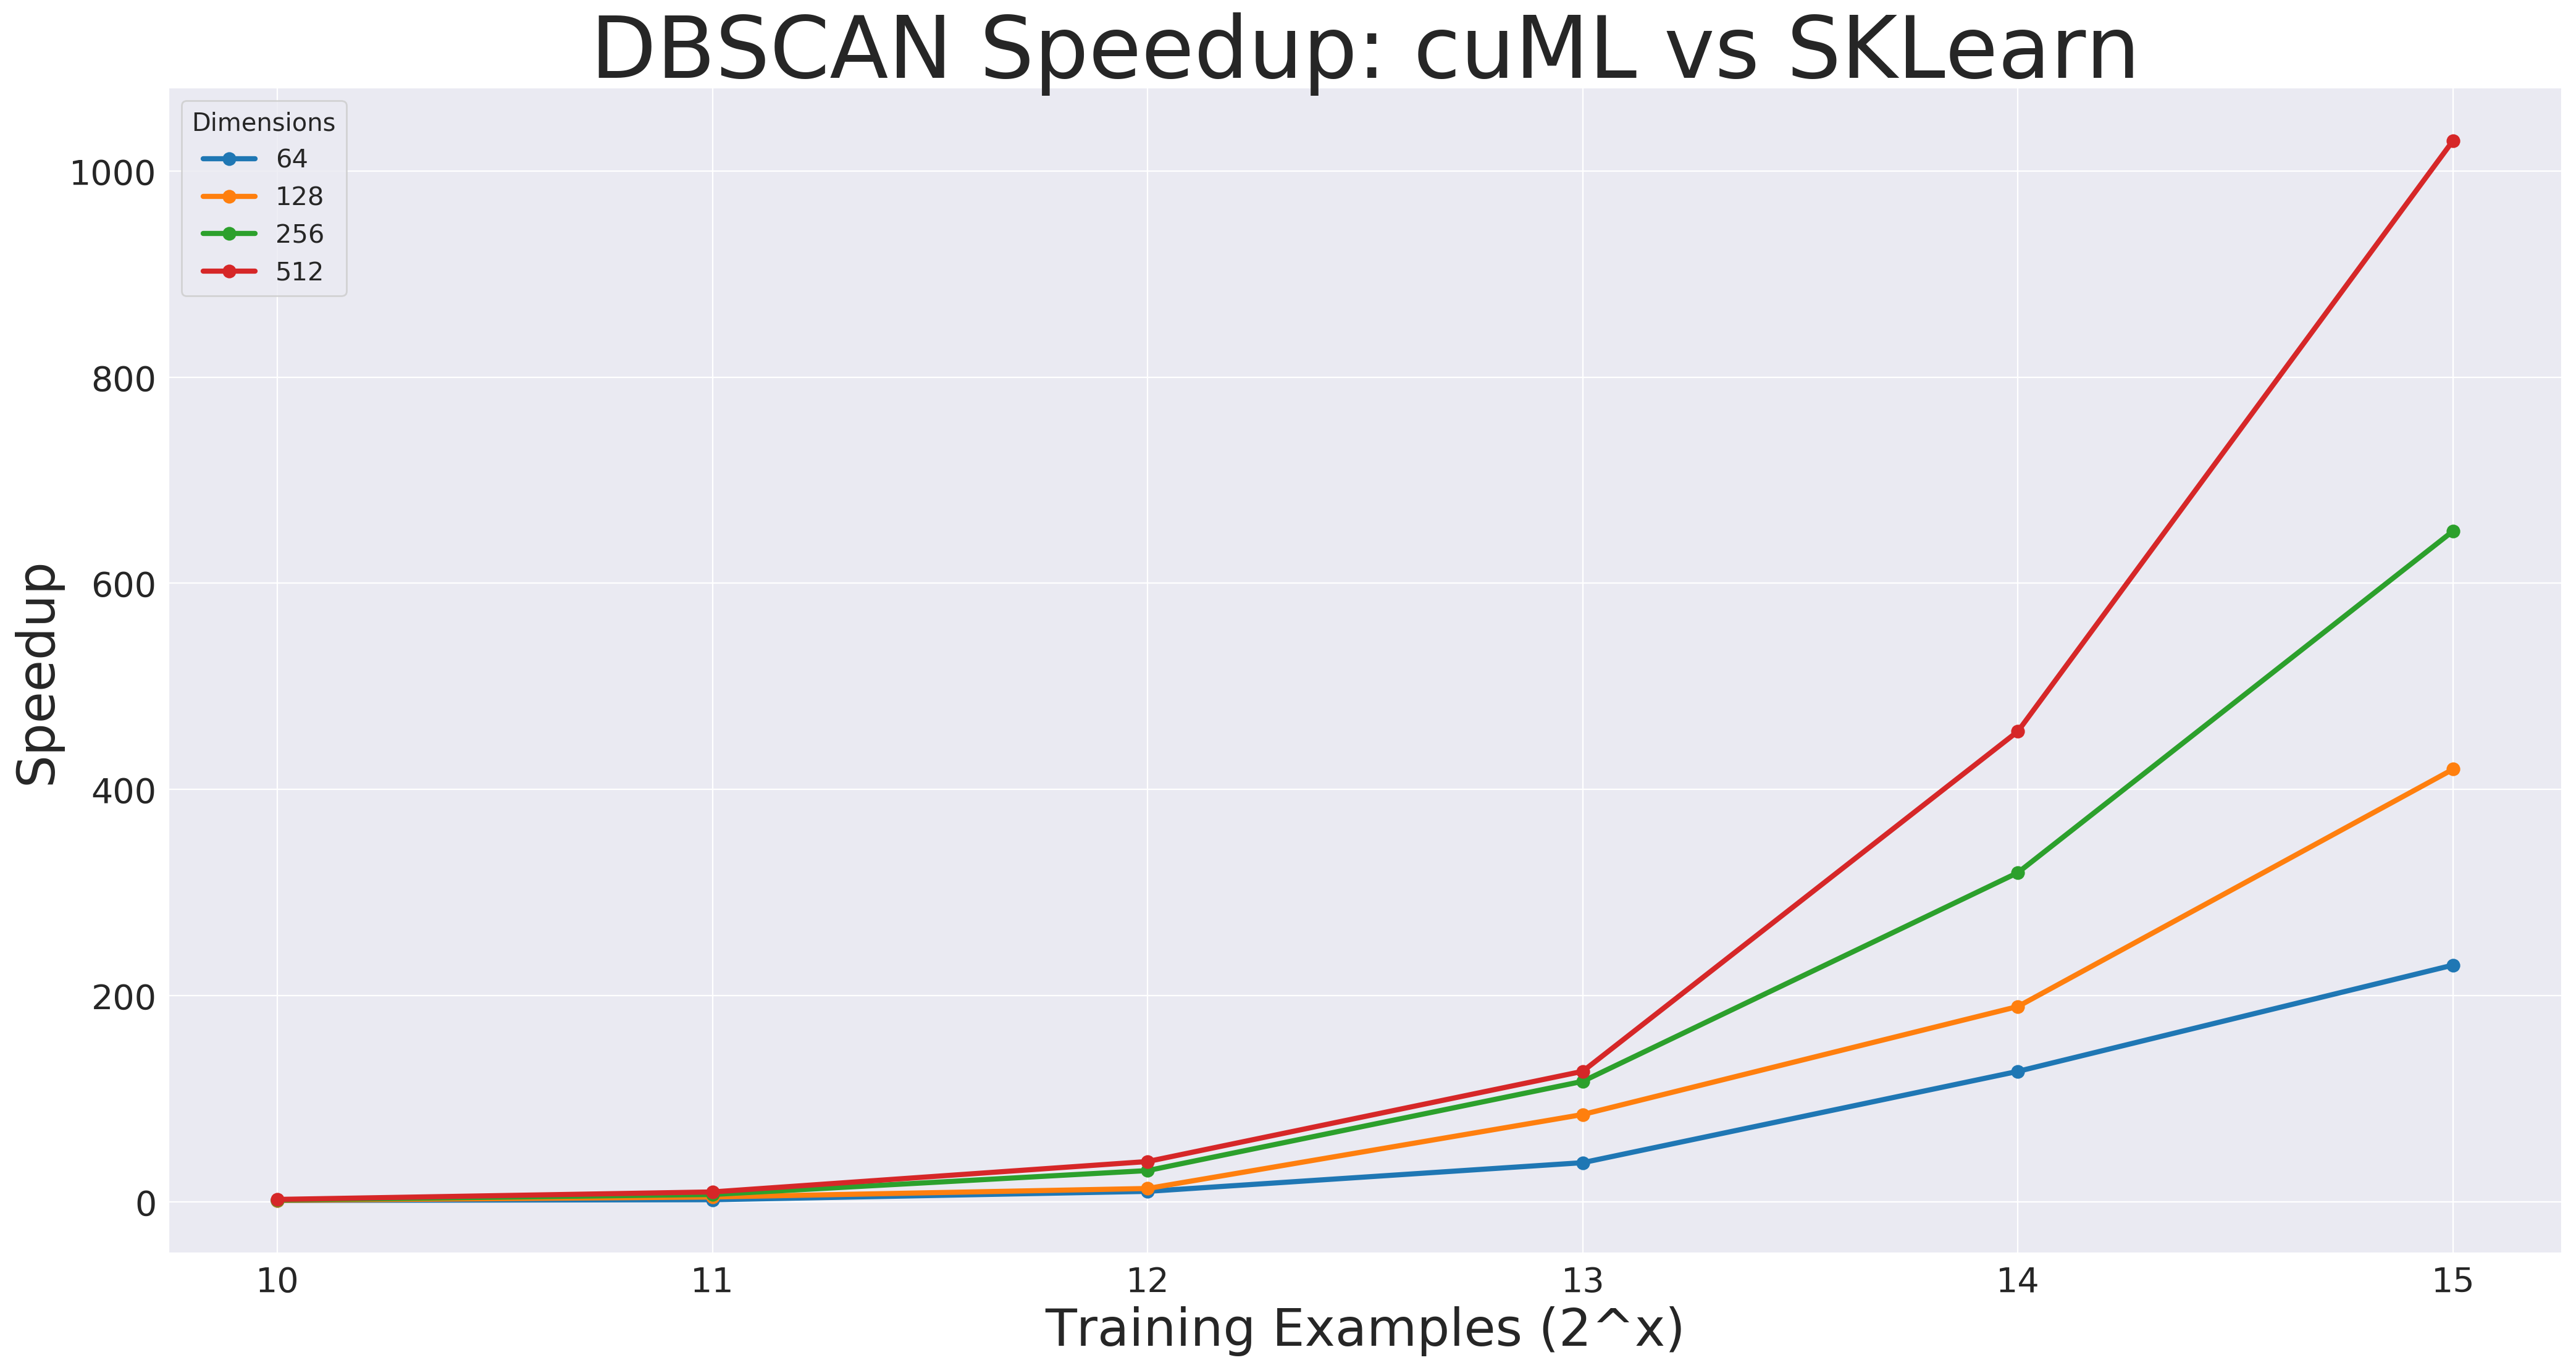

In [115]:
chart_results(final_results["dbscan"], title = "DBSCAN Speedup: cuML vs SKLearn")